In [1]:
%run imports/VacuumGauge_functions.ipynb
%run imports/rbflayer.py

import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


root_logdir = os.path.join(os.curdir, 'data/logs')

if not(os.path.exists(root_logdir)):
    !mkdir -p {root_logdir}
    print('{} succesfully created.'.format(root_logdir))
else:
    print('{} already exist.'.format(root_logdir))

def get_run_logdir(model_version):
    import time
    run_id = time.strftime('{}_run_%Y_%m_%d-%H_%M_%S'.format(model_version))
    return os.path.join(root_logdir, run_id)

./data/logs already exist.


### Tensorboard starting -- (only if needed)

In [51]:
%load_ext tensorboard
%tensorboard --logdir={root_logdir} --port=6006

## Reading the dataset

- df_ok: labels of ok gauges
- df_delta: labels of delta gauges
- df_ raw: raw data cointaining the full reading of each gauge

In [2]:
df_delta = pd.read_csv('data/datasets/df_delta.csv') # cointains labels for delta VG
df_ok = pd.read_csv('data/datasets/df_ok.csv')  #contains labels for ok VG

df_raw = pd.read_csv('data/datasets/df_raw.csv') ## contains full reading of each VG

df_labels = pd.concat([df_ok, df_delta], sort=False, axis=0)


df_VG = pd.merge(df_raw, df_labels, on =['gauge_id','fillNumber'])
df_VG = df_VG.set_index(['gauge_id','fillNumber'], drop=True)

## Removing categorical values
df_VG.y.replace(to_replace=['ok', 'delta'], value=[0, 1], inplace=True)

## Splitting the dataset in input and target
- X are the input features
- y is the target vector

Definition of a StratifiedKFold split to be used in all the grid searchs for all the model: 

In [3]:
X = np.array(df_VG.iloc[:, :-1])
y = np.array(df_VG.iloc[:, -1])

from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Hold out a test set for final evaluation

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit


# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# print(sss)

# for train_index, test_index in sss.split(X, y):
#     print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


# print(len(y_train))
# print(sum(y_train))
# print(len(y_test))
# print(sum(y_test))

## Preprocessing

The preprocessing of the input is divided in 3 steps:

1. Max pooling layer with kernel 15 and strides 15: reduce the dimensionality of a factor 15 keeping the max values, it preserve the interesting part of the signal
2. Median filter with kernel 9 to get rid of evenutally present white noise
3. Scaling of each time series to help gradient descent converge

In [4]:
import scipy
from skimage.measure import block_reduce

## Tensorflow implementation of max_pool

# X_max = X.reshape((X.shape[0], 3000, 1))  
# X_max = tf.nn.max_pool1d(X_max, ksize=15, strides=15, padding='VALID')
# X_max = X_max[...,0]

## Numpy implementation of max_pool

X_max = block_reduce(X, block_size=(1,15), func=np.max)

X_med = np.apply_along_axis(scipy.signal.medfilt, axis=1, arr= X_max, kernel_size=9)

scaler = RowScaler(scaling_method='Standard')

X_norm = scaler.fit_transform(X_med)

# X_f = np.fft.fft(X_avg, X_avg.shape[-1])
# X_f = np.fft.fftshift(X_f, axes=-1)
X_norm.shape

(278, 200)

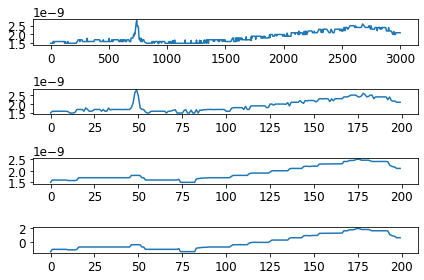

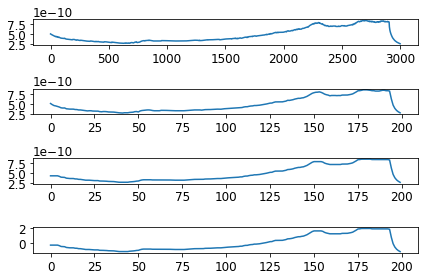

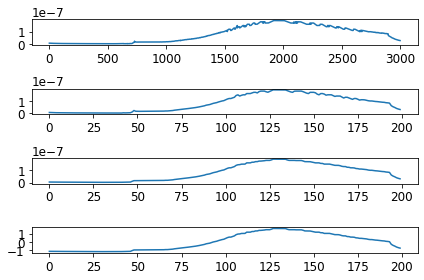

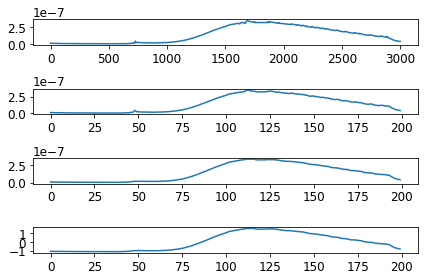

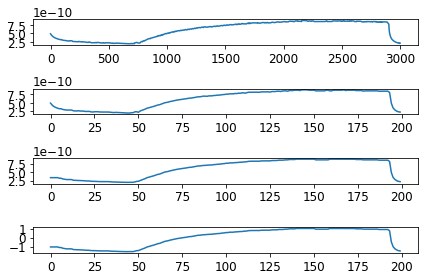

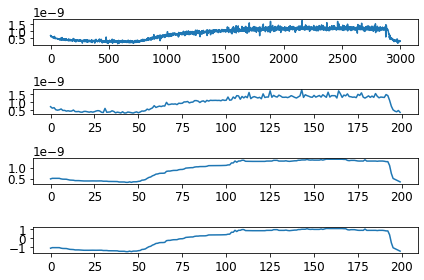

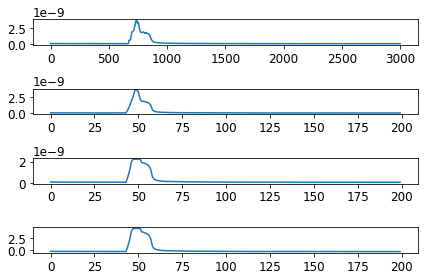

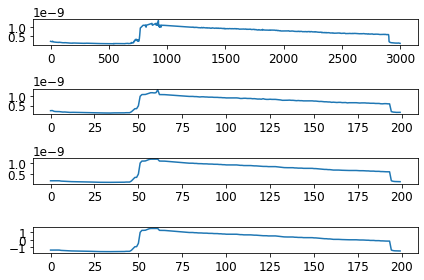

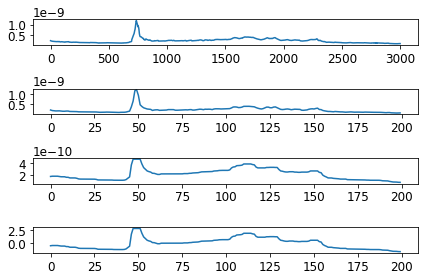

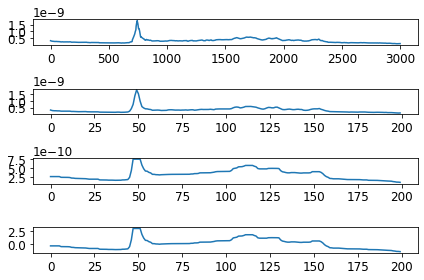

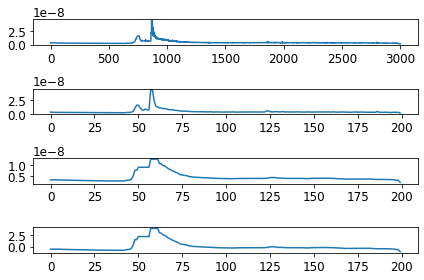

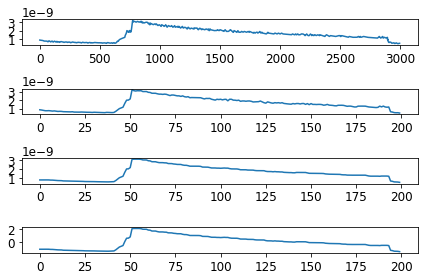

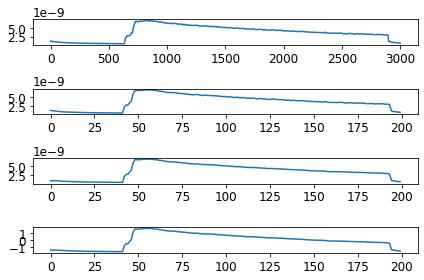

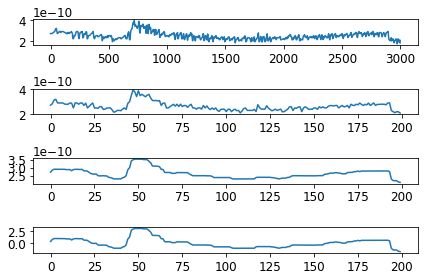

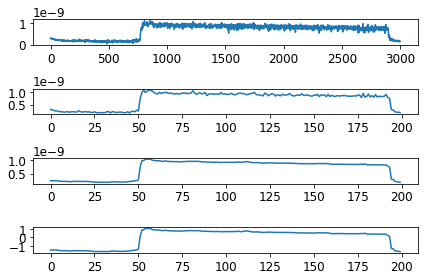

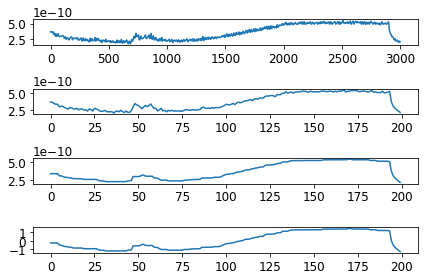

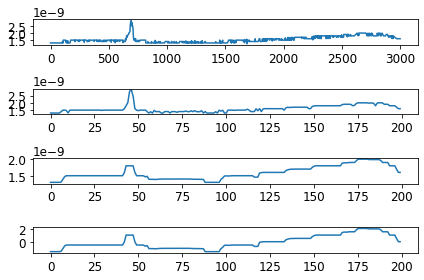

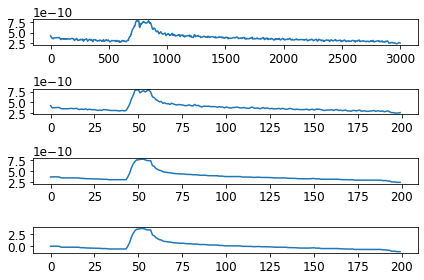

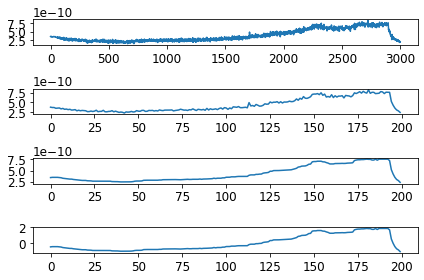

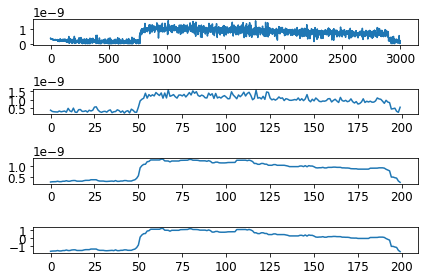

In [5]:
for i in range(20, 40, 1):
    plt.subplot(4,1,1)
    plt.plot(X[i])
    plt.subplot(4,1,2)
    plt.plot(X_max[i])
    plt.subplot(4,1,3)
    plt.plot(X_med[i])
    plt.subplot(4,1,4)
    plt.plot(X_norm[i])
    plt.tight_layout()
    plt.show()

## Quick overview on the PCA impact

PCA performed on the trainig part of the normalised dataset to visualize its impact.

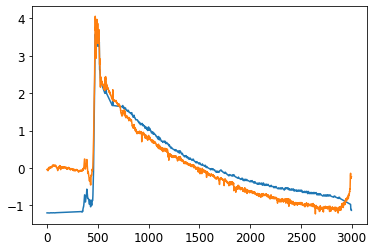

In [54]:

scaler = RowScaler('Standard')
# X_norm = scaler.fit_transform(X)
# X_norm[0].shape

i=100
X_m = scaler.fit_transform(X) - scaler.fit_transform(X).mean(axis=0, keepdims=0)
plt.figure()
plt.plot(range(3000), scaler.fit_transform(X)[i])
plt.plot(range(3000), X_m[i])
plt.show()

In [79]:
preprocess = Prepocess()
scaler = RowScaler('Standard')

pca = PCA(n_components=3)


X_pca = pca.fit_transform(scaler.fit_transform(preprocess.fit_transform(X)))
X_pca = pca.fit_transform(scaler.fit_transform(X))
X_pca[1]

array([-18.09394979, -23.95543694,   0.97484352])

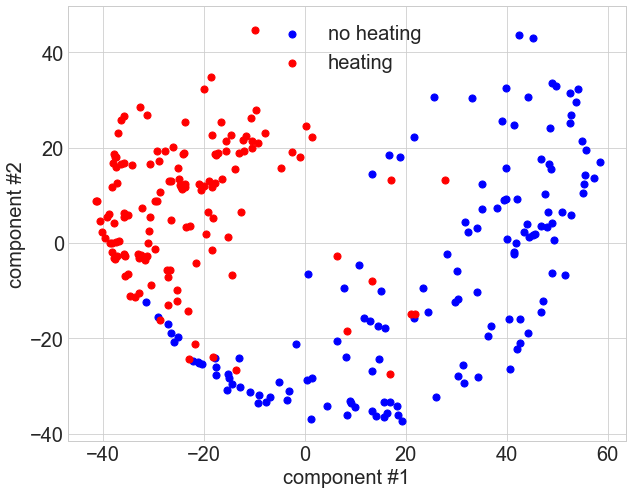

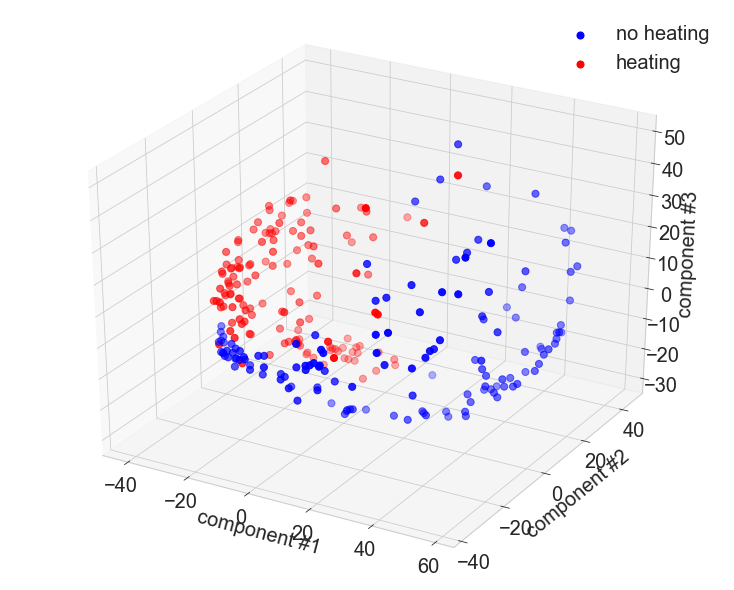

In [80]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fontsize=15

ok = X_pca[y==0]
delta = X_pca[y ==1]


plt.style.use('seaborn-whitegrid')
fontsize=20

plt.figure(figsize=(10,8))
plt.scatter(ok[:,0], ok[:,1], c='b', label='no heating', s=50)
plt.scatter(delta[:,0], delta[:,1], c='r', label='heating', s=50)

plt.legend(fontsize=fontsize)
plt.xlabel('component #1', fontsize=fontsize)
plt.ylabel('component #2', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.grid(True)
plt.show()

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(ok[:,0], ok[:,1], ok[:,2], c='b', label='no heating', s=50)
ax.scatter(delta[:,0], delta[:,1], delta[:,2], c='r', label='heating', s=50)

ax.set_xlabel('component #1', fontsize=fontsize)
ax.set_ylabel('component #2', fontsize=fontsize)
ax.set_zlabel('component #3', fontsize=fontsize)

# ax.set_xlim(-25,30)
# ax.set_ylim(-5,20)
# ax.set_zlim(-10,7.5)
plt.gca().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


## Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = Pipeline([
    ('preprocessor', Prepocess()),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA(n_components=3)),
    ('forest', RandomForestClassifier())

])

model = forest_clf
model_dir = 'data/models/random_forest'
model_version = 'forest_002.pkl'
scoring = ['recall', 'accuracy', 'precision']

forest_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir,model_version))

data/models/random_forest/forest_002.pkl


#### GridSearch

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
     'forest__n_estimators': range(10,100, 20),
     'forest__max_leaf_nodes': range(3,8),
     'forest__bootstrap': [False],
    }
]


In [68]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  9.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Prepocess(max_pool_size=15,
                                                  median_size=9)),
                                       ('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=3, random_state=None,
                                            svd_solver='auto', tol=0....
             iid='warn', n_jobs=-1,
             param_grid=[{'forest__bootstrap': [False],
                          'forest__max_leaf_nodes': range(3, 8),
                          'forest__n_estimators': range(10, 100, 20),
         

In [69]:
printGridSearchResults(grid_search, scoring[0])

Best parameters set found on development set:
{'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 50, 'pca__n_components': 2, 'scaler__scaling_method': 'Robust'}

Grid scores on development set:

0.871 (+/-0.089) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 10, 'pca__n_components': 2, 'scaler__scaling_method': 'Standard'}
0.863 (+/-0.172) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 10, 'pca__n_components': 2, 'scaler__scaling_method': 'MinMax'}
0.755 (+/-0.331) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 10, 'pca__n_components': 2, 'scaler__scaling_method': 'MaxAbs'}
0.906 (+/-0.056) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 10, 'pca__n_components': 2, 'scaler__scaling_method': 'Robust'}
0.871 (+/-0.061) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 1

In [71]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor', Prepocess(max_pool_size=15, median_size=9)),
                ('scaler', RowScaler(scaling_method='Robust')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('forest',
                 RandomForestClassifier(bootstrap=False, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto', max_leaf_nodes=3,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=50, n_jobs=None,
                           

### Saving the model

In [72]:
save_model(grid_search, model_dir, model_version)

## Logistic Regressor (classifier)

In [82]:
from sklearn.linear_model import LogisticRegression

log_clf = Pipeline([
    ('preprocessor', Prepocess()),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA(n_components=3)),
    ('logistic', LogisticRegression())

])

model = log_clf
model_dir = 'data/models/logistic_classifier'
model_version = 'logistic_002.pkl'
scoring = ['recall', 'accuracy', 'precision']

log_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir, model_version))

data/models/logistic_classifier/logistic_002.pkl


In [83]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
     'logistic__solver': ['liblinear'],
     'logistic__penalty': ['l1', 'l2']
    }
]

In [84]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   55.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Prepocess(max_pool_size=15,
                                                  median_size=9)),
                                       ('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=3, random_state=None,
                                            svd_solver='auto', tol=0....
                                                           verbose=0,
                                                           warm_start=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
  

In [89]:
printGridSearchResults(grid_search, scoring[2])

Best parameters set found on development set:
{'logistic__penalty': 'l1', 'logistic__solver': 'liblinear', 'pca__n_components': 5, 'scaler__scaling_method': 'MaxAbs'}

Grid scores on development set:

0.933 (+/-0.122) for {'logistic__penalty': 'l1', 'logistic__solver': 'liblinear', 'pca__n_components': 2, 'scaler__scaling_method': 'Standard'}
0.896 (+/-0.139) for {'logistic__penalty': 'l1', 'logistic__solver': 'liblinear', 'pca__n_components': 2, 'scaler__scaling_method': 'MinMax'}
0.775 (+/-0.155) for {'logistic__penalty': 'l1', 'logistic__solver': 'liblinear', 'pca__n_components': 2, 'scaler__scaling_method': 'MaxAbs'}
0.812 (+/-0.176) for {'logistic__penalty': 'l1', 'logistic__solver': 'liblinear', 'pca__n_components': 2, 'scaler__scaling_method': 'Robust'}
0.919 (+/-0.118) for {'logistic__penalty': 'l1', 'logistic__solver': 'liblinear', 'pca__n_components': 3, 'scaler__scaling_method': 'Standard'}
0.951 (+/-0.082) for {'logistic__penalty': 'l1', 'logistic__solver': 'liblinear', 'pc

In [86]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor', Prepocess(max_pool_size=15, median_size=9)),
                ('scaler', RowScaler(scaling_method='MaxAbs')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

### Saving the model

In [90]:
#print(grid_search)
save_model(grid_search, model_dir, model_version)

## KNN

In [91]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = Pipeline([
    ('preprocessor', Prepocess()),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())

])

model = knn_clf
model_dir = 'data/models/knn'
model_version = 'knn_002.pkl'
scoring = ['recall', 'accuracy', 'precision']

knn_path = os.path.join(model_dir, model_version)
print(os.path.join(model_dir, model_version))

data/models/knn/knn_002.pkl


In [92]:
param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
     'knn__n_neighbors': range(3,7),
     'knn__n_jobs': [-1]
    }
]

In [93]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Prepocess(max_pool_size=15,
                                                  median_size=9)),
                                       ('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol...
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                            

In [98]:
printGridSearchResults(grid_search, scoring[1])

Best parameters set found on development set:
{'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 3, 'scaler__scaling_method': 'MaxAbs'}

Grid scores on development set:

0.942 (+/-0.028) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 2, 'scaler__scaling_method': 'Standard'}
0.939 (+/-0.036) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 2, 'scaler__scaling_method': 'MinMax'}
0.795 (+/-0.106) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 2, 'scaler__scaling_method': 'MaxAbs'}
0.817 (+/-0.073) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 2, 'scaler__scaling_method': 'Robust'}
0.960 (+/-0.027) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 3, 'scaler__scaling_method': 'Standard'}
0.953 (+/-0.043) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 3, 'scaler__scaling_method': 'MinMax'}
0.953 (+/-0.048) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca_

In [95]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor', Prepocess(max_pool_size=15, median_size=9)),
                ('scaler', RowScaler(scaling_method='MaxAbs')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=3,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)

In [96]:
save_model(grid_search, model_dir, model_version)

## CNN 

In [ ]:
Calcolare false positive rate sui casi non labellati
cercare di ridurre il numero di features in maniera intell tipo filtro media
provare la derivata ed eventualmente lstm con 2 input (derivata e segnale)


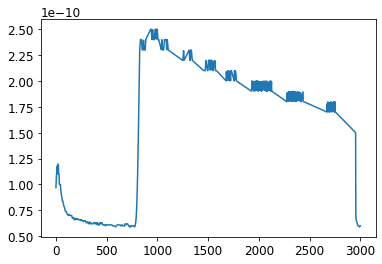

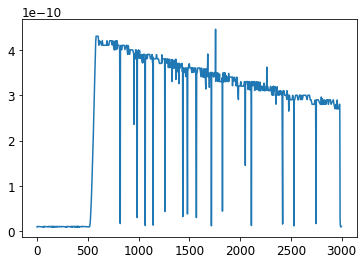

In [52]:
plt.plot(range(3000), X[0])
plt.show()
plt.plot(range(3000), X[150])
plt.show()

In [ ]:
Mettere epoch in grid search, fare bayes search, usare modello semplice con meno parametri

In [4]:
# print(X.shape)
# plt.plot(range(3000), X[0])
# plt.show()

from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
TRAIN size: 222 TEST size: 56


Function that builds the CNN for the gridsearch. Each layer is a Conv1D and a maxpool. Each layer reduce the second axis dimension of a factor 2.

In [48]:
keras.backend.clear_session()



def build_CNN(layers=1, filters=32, kernel_size=10,
              pool_size=5, strides=1):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Lambda(lambda X: rowScale(X), input_shape=[3000]))
    model.add(keras.layers.Reshape((3000, 1)))

    for layer in range(layers):
        model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                      activation='relu', strides=strides,
                                      padding='same', use_bias=True, kernel_initializer='he_normal'))
        model.add(keras.layers.MaxPool1D(pool_size=pool_size, padding='same'))

    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=5, activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    # learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
    #                                                             decay_steps= batch_size ,
    #                                                             decay_rate=0.1)
    optimizer = keras.optimizers.Nadam(learning_rate=1e-5)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=keras.metrics.binary_accuracy)
    return model

model = build_CNN(layers=1, pool_size=40, strides=5)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 3000)              0         
_________________________________________________________________
reshape (Reshape)            (None, 3000, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 32)           352       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2405      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [44]:
epochs = 500
run_log_dir = get_run_logdir('cnn')
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
history = model.fit(X_train, y_train,
                    epochs=epochs, verbose=1, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[tensorboard_cb])

Epoch 1/500
7/7 [==============================] - 1s 94ms/step - loss: 1.1444 - accuracy: 0.5045 - val_loss: 0.9027 - val_accuracy: 0.5000
Epoch 2/500
7/7 [==============================] - 0s 36ms/step - loss: 1.1252 - accuracy: 0.5045 - val_loss: 0.8867 - val_accuracy: 0.5000
Epoch 3/500
7/7 [==============================] - 0s 34ms/step - loss: 1.1044 - accuracy: 0.5045 - val_loss: 0.8701 - val_accuracy: 0.5000
Epoch 4/500
7/7 [==============================] - 0s 30ms/step - loss: 1.0818 - accuracy: 0.5045 - val_loss: 0.8533 - val_accuracy: 0.5000
Epoch 5/500
7/7 [==============================] - 0s 28ms/step - loss: 1.0589 - accuracy: 0.5090 - val_loss: 0.8366 - val_accuracy: 0.5000
Epoch 6/500
7/7 [==============================] - 0s 24ms/step - loss: 1.0373 - accuracy: 0.5090 - val_loss: 0.8204 - val_accuracy: 0.5000
Epoch 7/500
7/7 [==============================] - 0s 23ms/step - loss: 1.0146 - accuracy: 0.5090 - val_loss: 0.8045 - val_accuracy: 0.5000
Epoch 8/500
7/7 [===

In [22]:
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=1e-5, s=-17)    
epochs = 500
run_log_dir = get_run_logdir('cnn')
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)  

lr = [exponential_decay_fn(epoch) for epoch in range(100)]
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
epochs = 100
class_weight = {0: 1.,
                1: 1.}
history = model.fit(X_train, y_train,
                    epochs=epochs, verbose=1, class_weight=class_weight,
                    validation_data=(X_test, y_test),
                    callbacks= [lr_scheduler, tensorboard_cb])

Epoch 1/100
7/7 [==============================] - 1s 189ms/step - loss: 0.8731 - precision: 0.3494 - val_loss: 0.8979 - val_precision: 0.3636 - lr: 1.0000e-05
Epoch 2/100
7/7 [==============================] - 0s 29ms/step - loss: 0.8667 - precision: 0.3537 - val_loss: 0.8913 - val_precision: 0.3636 - lr: 1.1450e-05
Epoch 3/100
7/7 [==============================] - 0s 31ms/step - loss: 0.8587 - precision: 0.3659 - val_loss: 0.8824 - val_precision: 0.3636 - lr: 1.3111e-05
Epoch 4/100
7/7 [==============================] - 0s 25ms/step - loss: 0.8485 - precision: 0.3704 - val_loss: 0.8720 - val_precision: 0.3636 - lr: 1.5013e-05
Epoch 5/100
7/7 [==============================] - 0s 29ms/step - loss: 0.8371 - precision: 0.3827 - val_loss: 0.8599 - val_precision: 0.3636 - lr: 1.7191e-05
Epoch 6/100
7/7 [==============================] - 0s 23ms/step - loss: 0.8243 - precision: 0.4177 - val_loss: 0.8458 - val_precision: 0.3636 - lr: 1.9684e-05
Epoch 7/100
7/7 [============================

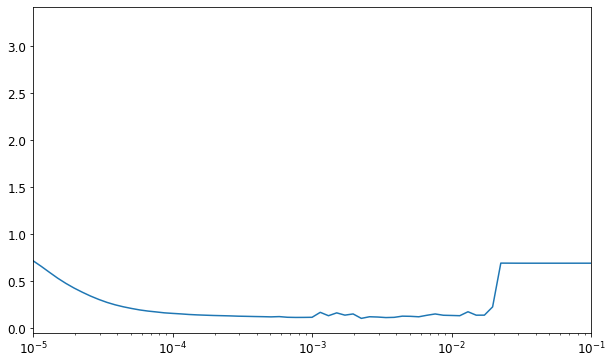

In [143]:
plt.figure(figsize=(10,6))
plt.plot(lr, history.history['val_loss'])
plt.xlim(1e-5, 1e-1)
plt.xscale('log')
plt.show()

In [231]:
y_true = y_test
y_pred = model.predict_classes(X_test)
m = keras.metrics.Recall()
m.update_state(y_true, y_pred)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.96428573>

In [34]:
a = [0, 0, 1.2, 0.8]
b = [1, 1, 1, 1] 
keras.metrics.Accuracy()(tf.round(a),tf.round(b))

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = grid_search.best_estimator_.predict(X_test)

# y_pred = np.round(y_pred)
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

NameError: name 'grid_search' is not defined

In [128]:
cnn_clf = keras.wrappers.scikit_learn.KerasClassifier(build_CNN)

model = cnn_clf
model_dir = 'data/models/cnn'
model_version = 'cnn_001.pkl'
scoring = ['recall', 'accuracy', 'precision']


In [129]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'layers': [1],
     'pool_size' : [5],
     'strides' : [5],
     'kernel_size' : [5]
    }
]

In [130]:
keras.backend.clear_session()

print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=2, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[1]  ## Score used for final refit
)

grid_search.fit(X, y, epochs=100, verbose=2)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished
Epoch 1/100
9/9 - 0s - loss: 0.8304 - precision: 0.4964
Epoch 2/100
9/9 - 0s - loss: 0.8159 - precision: 0.4964
Epoch 3/100
9/9 - 0s - loss: 0.7996 - precision: 0.4964
Epoch 4/100
9/9 - 0s - loss: 0.7831 - precision: 0.4964
Epoch 5/100
9/9 - 0s - loss: 0.7672 - precision: 0.4964
Epoch 6/100
9/9 - 0s - loss: 0.7514 - precision: 0.4964
Epoch 7/100
9/9 - 0s - loss: 0.7361 - precision: 0.4964
Epoch 8/100
9/9 - 0s - loss: 0.7212 - precision: 0.4982
Epoch 9/100
9/9 - 0s - loss: 0.7063 - precision: 0.5000
Epoch 10/100
9/9 - 0s - loss: 0.6913 - precision: 0.5037
Epoch 11/100
9/9 - 0s - loss: 0.6770 - precision: 0.5075
Epoch 12/100
9/9 - 0s - loss: 0.6625 - precision: 0.5113
Epoch 13/100
9/9 - 0s - loss: 0.6480 - precision: 0.5191
Epoch 14/10

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x145f8d4a8>,
             iid='warn', n_jobs=-1,
             param_grid=[{'kernel_size': [5], 'layers': [1], 'pool_size': [5],
                          'strides': [5]}],
             pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
             scoring=['recall', 'accuracy', 'precision'], verbose=2)

In [127]:
printGridSearchResults(grid_search, scoring[1])

Best parameters set found on development set:
{'kernel_size': 5, 'layers': 1, 'pool_size': 5, 'strides': 5}

Grid scores on development set:

0.835 (+/-0.221) for {'kernel_size': 5, 'layers': 1, 'pool_size': 5, 'strides': 5}
0.831 (+/-0.114) for {'kernel_size': 10, 'layers': 1, 'pool_size': 5, 'strides': 5}
0.809 (+/-0.262) for {'kernel_size': 15, 'layers': 1, 'pool_size': 5, 'strides': 5}
0.788 (+/-0.257) for {'kernel_size': 20, 'layers': 1, 'pool_size': 5, 'strides': 5}


In [69]:
grid_search.best_estimator_.model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 3000)              0         
_________________________________________________________________
reshape (Reshape)            (None, 3000, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 10)           110       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 120, 10)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6005      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [106]:
cv_result = pd.DataFrame(grid_search.cv_results_)
cv_result.sort_values(by='mean_test_accuracy', ascending=False).loc[:, ['mean_test_recall','std_test_recall',
                                                                      'mean_train_recall', 'std_train_recall',
                                                                      'mean_test_precision','std_test_precision',
                                                                      'mean_train_precision', 'std_train_precision',
                                                                      'mean_test_accuracy','std_test_accuracy',
                                                                      'mean_train_accuracy', 'std_train_accuracy',
                                                                       ]]

,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,mean_train_precision,std_train_precision,mean_test_accuracy,std_test_accuracy,mean_train_accuracy,std_train_accuracy
3,0.956835,0.027280,0.992809,0.003596,1.000000,0.000000,1.000000,0.000000,0.978417,0.013640,0.996404,0.001798
22,0.964029,0.031914,0.985602,0.007219,0.985345,0.017846,1.000000,0.000000,0.974820,0.021400,0.992801,0.003610
9,0.956835,0.026751,0.987403,0.007215,0.985593,0.017558,0.998165,0.003670,0.971223,0.014213,0.992801,0.005409
0,0.942446,0.017965,0.998198,0.003604,0.992529,0.015216,1.000000,0.000000,0.967626,0.013921,0.999099,0.001802
4,0.956835,0.026751,0.989205,0.006746,0.978151,0.017953,1.000000,0.000000,0.967626,0.017617,0.994603,0.003373
18,0.964029,0.022675,0.989221,0.003539,0.965021,0.037923,1.000000,0.000000,0.964029,0.027768,0.994611,0.001770
7,0.949640,0.017313,0.976593,0.016723,0.978647,0.027901,0.992675,0.006775,0.964029,0.015814,0.984693,0.010121
1,0.942446,0.028426,0.991007,0.005698,0.985612,0.017787,1.000000,0.000000,0.964029,0.011346,0.995504,0.002849
20,0.956835,0.026573,0.983832,0.010457,0.965458,0.036679,0.992792,0.006699,0.960432,0.020688,0.988320,0.006077
13,0.942446,0.017152,0.971219,0.014421,0.978417,0.028616,0.989189,0.021622,0.960432,0.017307,0.980204,0.017478


NameError: name 'k' is not defined

## RBF

In [25]:
df_raw = pd.read_csv('data/datasets/df_raw.csv')
df_raw = df_raw[df_raw.fillNumber != 2011]

df_raw = df_raw.astype({'fillNumber': 'int'})
df_raw = df_raw.set_index(['gauge_id','fillNumber'], drop=True)
df_raw.index.get_level_values('fillNumber').value_counts()


kmeans_centers_path = 'data/datasets/k12_centers.npy'
silhouette_scores_path = 'data/datasets/silhouette_scores_range_2_20.npy'
inertias_path = 'data/datasets/intertias_range_2_20.npy'

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaler = RowScaler(scaling_method='Standard')
Xu_scaled = scaler.fit_transform(df_raw)

In [29]:
if os.path.exists(kmeans_centers_path):
    k12_centers = np.load(kmeans_centers_path)
    print('KMeans center loaded.')
else:
    print('Recomputing KMeans...')
    kmeans_per_k = [KMeans(n_clusters=k,
                                    algorithm='elkan',
                                    random_state=42,
                                    n_jobs=-1,
                                    verbose=2
                                    ).fit(X_scaled)
                    for k in range(2, 20)]
    k12_centers = np.array(kmeans_per_k[12 -2].cluster_centers_)
    np.save('data/datasets/k12_centers.npy', k12_centers)



if os.path.exists(inertias_path):
    inertias = np.load(inertias_path)
    print('inertias loaded.')
else:
    inertias = [model.inertia_ for model in kmeans_per_k]
    np.save(inertias_path, inertias)
    print('inertias saved.')

if os.path.exists(silhouette_scores_path):
    silhouette_scores = np.load(silhouette_scores_path)
    print('silhouette loaded')
else:
    silhouette_scores = [silhouette_score(X_scaled, model.labels_)
                         for model in kmeans_per_k]
    np.save(silhouette_scores_path, silhouette_scores)
    print('silhouette saved')

KMeans center loaded.
inertias loaded.
silhouette loaded


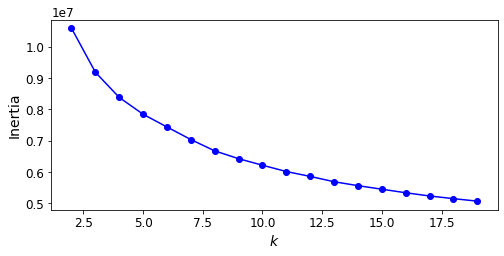

In [28]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 20), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.grid(False)
plt.show()

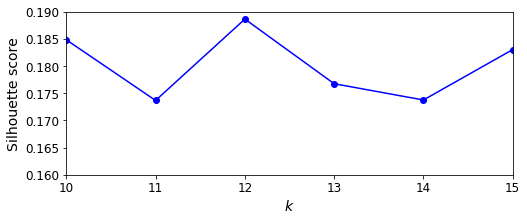

In [30]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.xlim(10,15)
plt.ylim(0.16, 0.19)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [31]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (10, 11, 12, 13):
    plt.subplot(2, 2, k - 9)
    
    y_pred = kmeans_per_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X_scaled, y_pred)

    padding = len(X_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (10, 12):
        plt.ylabel("Cluster")
    
    if k in (12, 13):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

NameError: name 'kmeans_per_k' is not defined

In [ ]:
len(kmeans_per_k[12 -2].cluster_centers_)
k12_centers.shape

In [ ]:
k12_centers = np.load('data/datasets/k12_centers.npy')
for c in k12_centers:
    plt.plot(range(3000), c)
    plt.show()

In [38]:
from sklearn.metrics.pairwise import euclidean_distances

d_max = np.max(euclidean_distances(k12_centers, k12_centers))
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Lambda(lambda X: rowScale(X), input_shape=[3000]))
model.add(RBFLayer(12,
                    initializer=InitFromFile('data/datasets/k12_centers.npy'),
                    betas=d_max/np.sqrt(len(k12_centers)),
                    trainable=False,
                    input_shape=[3000])
                    )
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.add(keras.layers.Lambda(lambda X: tf.round(X)))

optimizer = keras.optimizers.Adam()

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=[keras.metrics.Recall()])

model.summary()
model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 3000)              0         
_________________________________________________________________
rbf_layer (RBFLayer)         (None, 12)                36012     
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 36,025
Trainable params: 13
Non-trainable params: 36,012
_________________________________________________________________


[array([[-2.1164005 , -2.119006  , -2.1362445 , ..., -1.7929586 ,
         -1.8011711 , -1.8127755 ],
        [-2.3814256 , -2.3917806 , -2.3915775 , ..., -1.7250103 ,
         -1.7411628 , -1.7454612 ],
        [-0.45441002, -0.4406159 , -0.46756515, ..., -0.6748551 ,
         -0.6775143 , -0.67403114],
        ...,
        [-1.4720175 , -1.4963709 , -1.4938457 , ..., -1.2250153 ,
         -1.2230327 , -1.2192667 ],
        [-0.52028614, -0.5281814 , -0.5321289 , ..., -0.5307569 ,
         -0.54318655, -0.542097  ],
        [-1.1610963 , -1.1430545 , -1.1023331 , ..., -0.3745212 ,
         -0.36989984, -0.45521298]], dtype=float32),
 array([23.415413, 23.415413, 23.415413, 23.415413, 23.415413, 23.415413,
        23.415413, 23.415413, 23.415413, 23.415413, 23.415413, 23.415413],
       dtype=float32),
 array([[ 0.2552939 ],
        [-0.02108914],
        [ 0.5856061 ],
        [-0.33671156],
        [ 0.31407642],
        [ 0.5333952 ],
        [ 0.6070113 ],
        [ 0.33877838],
  

In [39]:
history = model.fit(X, y, epochs=5, validation_split=0.33, verbose=1)
y_pred = model.predict(X[-50:])

Epoch 1/5


ValueError: in user code:

    /Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:541 train_step  **
        self.trainable_variables)
    /Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1804 _minimize
        trainable_variables))
    /Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1219 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['dense/kernel:0', 'dense/bias:0'].


In [37]:
y_pred

array([[0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426],
       [0.503426]], dtype=float32)

In [9]:
11 // 2

5

domande:
devo abilitare il training sul layer RBF? iniziamo senza farlo
definire modelli finali: pca solo su training, kmeans su tutto unlabelled
train - val- test split, va bene? No usiamo solo k fold
quante fold nel k fold? meglio 10
perche RNN cosi lenta?